In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import joblib

# --- Fraud ---
logreg_f = joblib.load(f"/content/drive/MyDrive/models/fraud_logreg_pipeline.joblib")
xgb_f    = joblib.load(f"/content/drive/MyDrive/models/fraud_xgb_pipeline.joblib")

# Use directly on raw fraud dataframe with the same columns you trained on:
# proba = xgb_f.predict_proba(fraud_df[num_cols + cat_cols])[:, 1]

# --- CreditCard ---
logreg_c = joblib.load(f"/content/drive/MyDrive/models/cc_logreg_model.joblib")
xgb_c    = joblib.load(f"/content/drive/MyDrive/models/cc_xgb_model.joblib")
sc_cc    = joblib.load(f"/content/drive/MyDrive/models/cc_scaler.joblib")

# Example inference on credit card data:
# X_new_sc = sc_cc.transform(X_new)        # scale first
# proba = xgb_c.predict_proba(X_new_sc)[:, 1]


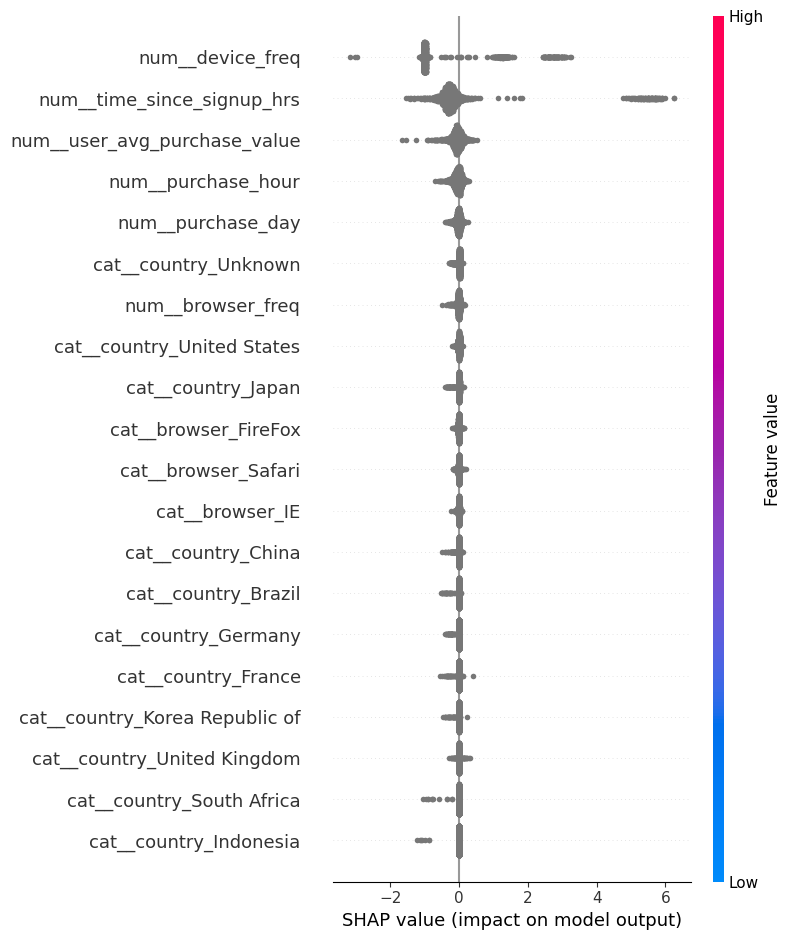

In [8]:
# --- Setup
!pip -q install shap
import shap, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

# Paths
FRAUD_CSV = "/content/drive/MyDrive/fraud_df.csv"  # <-- edit if needed

# Columns used at train time
num_cols = [
    'purchase_hour','purchase_day','time_since_signup_hrs',
    'user_transaction_count','user_avg_purchase_value',
    'user_purchase_std','is_first_transaction','device_freq','browser_freq'
]
cat_cols = ['country','browser']

# 1) Load the same fraud_df you trained with
fraud_df = pd.read_csv(FRAUD_CSV)

# 2) Recreate X, y and the SAME split (random_state=42)
X = fraud_df[num_cols + cat_cols]
y = fraud_df['class'].astype(int)

Xf_tr_raw, Xf_te_raw, yf_tr, yf_te = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3) Use the saved pipeline's preprocessor to transform test
preproc = xgb_f.named_steps["pre"]
Xf_te_proc = preproc.transform(Xf_te_raw)

# 4) Build SHAP explainer on the saved XGBoost inside the pipeline
xgb_clf = xgb_f.named_steps["clf"]
explainer = shap.TreeExplainer(xgb_clf)

# For speed, sample up to 2000 rows
idx = np.random.RandomState(42).choice(Xf_te_proc.shape[0], size=min(2000, Xf_te_proc.shape[0]), replace=False)
X_sample = Xf_te_proc[idx]

# 5) Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 6) Feature names for plots
try:
    feature_names = preproc.get_feature_names_out()
except:
    feature_names = None

# 7) Summary (global) plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

# 8) Force plot for a single example (local explanation)
shap.initjs()
i = 0  # pick any index within the sampled set
base_value = explainer.expected_value
sample_row = X_sample[i]

# If sparse, convert one row to dense 1D
if hasattr(sample_row, "toarray"):
    sample_row = sample_row.toarray().ravel()

shap.force_plot(base_value, shap_values[i], sample_row, feature_names=feature_names)


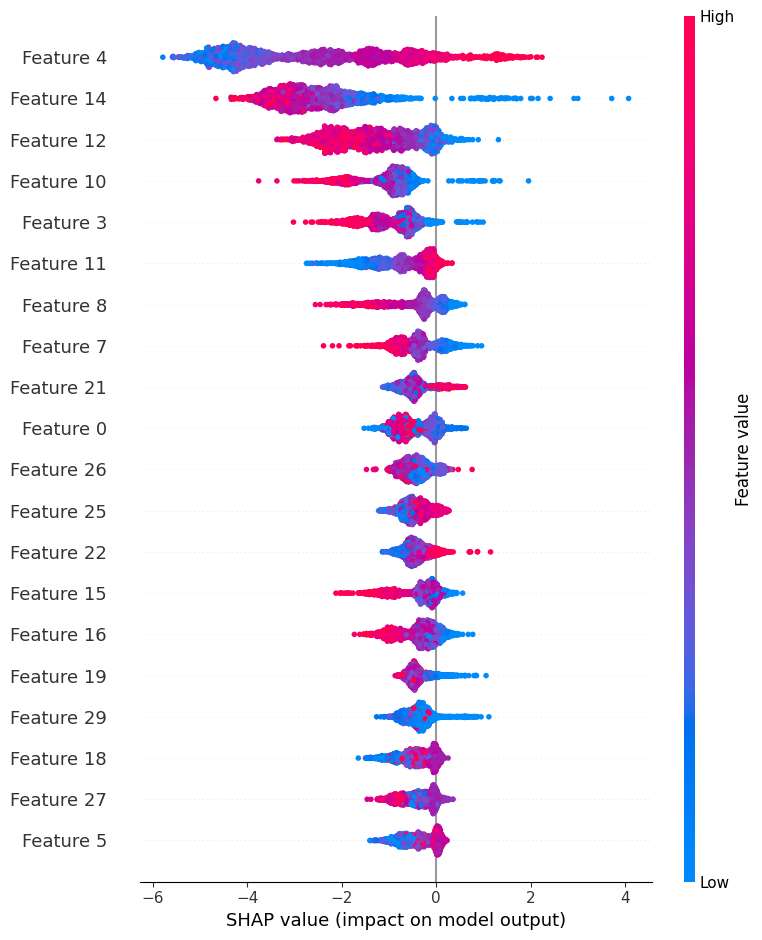

In [11]:
# Paths
CC_CSV = "/content/drive/MyDrive/creditcard.csv"  # <-- edit if needed

# 1) Load & split (same seed as training)
cc = pd.read_csv(CC_CSV).dropna()
X_c = cc.drop(columns=["Class"])
y_c = cc["Class"].astype(int)

from sklearn.model_selection import train_test_split
Xc_tr_raw, Xc_te_raw, yc_tr, yc_te = train_test_split(
    X_c, y_c, test_size=0.30, random_state=42, stratify=y_c
)

# 2) Scale test with the saved scaler
Xc_te = sc_cc.transform(Xc_te_raw)

# 3) SHAP on saved credit-card XGBoost
explainer_cc = shap.TreeExplainer(xgb_c)

idx = np.random.RandomState(42).choice(Xc_te.shape[0], size=min(2000, Xc_te.shape[0]), replace=False)
Xc_sample = Xc_te[idx]

shap_values_cc = explainer_cc.shap_values(Xc_sample)

# Summary plot (global)
shap.summary_plot(shap_values_cc, Xc_sample)

# Force plot (local)
shap.initjs()
i = 0
shap.force_plot(explainer_cc.expected_value, shap_values_cc[i], Xc_sample[i])
